This notebook provides an environment for testing changes to the HDFS path parser we use to classify and track the contents of HDFS.

To see how things will change, we can compare what we get against the current production results: http://intranet.wa.bl.uk/ukwa-reports/reports/hdfs/

First we need to get an up-to-date copy of the full listing of files on HDFS. These are generated daily and placed on HDFS.

In [4]:
#!pip install hdfs
from hdfs import InsecureClient
client = InsecureClient('http://dls.httpfs.wa.bl.uk:14000', user='access')

# Show what we have:
for filename in client.list('/9_processing/task-state/hdfs/2019-07/'):
    print(filename)

# Download one:
#!hdfscli download /9_processing/task-state/hdfs/2019-07/2019-07-04-hdfs-all-files-list.csv.gz .
#!gunzip 2019-07-04-hdfs-all-files-list.csv.gz

2019-07-01-hdfs-all-files-list.csv.gz
2019-07-02-hdfs-all-files-list.csv.gz
2019-07-03-hdfs-all-files-list.csv.gz
2019-07-04-hdfs-all-files-list.csv.gz


In [7]:
!ls -lh

total 586M
-rw-r--r--. 1 anj users 525M Jul  4 09:31 2019-07-04-hdfs-all-files-list.csv
-rw-r--r--. 1 anj users  37M Jul  4 21:59 2019-07-04-hdfs-all-files-list.csv.gz
-rw-r--r--. 1 anj users  26M Jul  4 22:01 hdfs-parsed-paths.csv
-rw-r--r--. 1 anj users  17K Jul  4 22:00 hdfs-path-parser.ipynb
-rw-r--r--. 1 anj users    0 Jul  4 09:39 __init__.py
-rw-r--r--. 1 anj users   72 Jul  4 09:39 Untitled.ipynb


Now we can run the path parser on it:

In [47]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import re
import csv
import enum
import datetime
    
#from tasks.analyse.hdfs_analysis import HdfsPathParser, ListAllFilesOnHDFSToLocalFile

class HdfsPathParser(object):
    """
    This class takes a HDFS file path and determines what, if any, crawl it belongs to, etc.
    """

    @staticmethod
    def field_names():
        """This returns the extended set of field names that this class derives from the basic listing."""
        return ['recognised', 'collection', 'stream','job', 'kind', 'permissions', 'number_of_replicas', 'user_id', 'group_id', 'file_size', 'modified_at', 'timestamp', 'file_path', 'file_name', 'file_ext']

    def __init__(self, item):
        """
        Given a string containing the absolute HDFS file path, parse it to work our what kind of thing it is.

        Determines crawl job, launch, kind of file, etc.

        For WCT-era selective content, the job is the Target ID and the launch is the Instance ID.

        :param file_path:
        """

        # Perform basic processing:
        # ------------------------------------------------
        # To be captured later
        self.recognised = False
        self.collection = None
        self.stream = None
        self.job = None
        self.kind = 'unknown'
        # From the item listing:
        self.permissions = item['permissions']
        self.number_of_replicas = item['number_of_replicas']
        self.user_id = item['userid']
        self.group_id = item['groupid']
        self.file_size = item['filesize']
        self.modified_at = item['modified_at']
        self.file_path = item['filename']
        # Derived:
        self.file_name = os.path.basename(self.file_path)
        first_dot_at = self.file_name.find('.')
        if first_dot_at != -1:
            self.file_ext = self.file_name[first_dot_at:]
        else:
            self.file_ext = None
        self.timestamp_datetime = datetime.datetime.strptime(item['modified_at'], "%Y-%m-%dT%H:%M:%S")
        self.timestamp = self.timestamp_datetime.isoformat()
        self.launch_datetime = None

        # Look for different filename patterns:
        # ------------------------------------------------
        self.analyse_file_path()

        # Now Add data based on file kind and file name...
        # ------------------------------------------------

        # Distinguish 'bad' crawl files, e.g. warc.gz.open files that are down as warcs
        if self.kind == 'warcs':
            if not self.file_name.endswith(".warc.gz"):
                # The older selective crawls allowed CDX files alongside the WARCs:
                if self.collection == 'selective' and self.file_name.endswith(".warc.cdx"):
                    self.kind = 'cdx'
                else:
                    self.kind = 'warcs-invalid'
            else:
                # Attempt to parse file timestamp out of filename,
                # Store ISO formatted date in self.timestamp, datetime object in self.timestamp_datetime
                mwarc = re.search('^.*-([12][0-9]{16})-.*\.warc\.gz$', self.file_name)
                if mwarc:
                    self.timestamp_datetime = datetime.datetime.strptime(mwarc.group(1), "%Y%m%d%H%M%S%f")
                    self.timestamp = self.timestamp_datetime.isoformat()
                else:
                    if self.stream and self.launch_datetime:
                        # fall back on launch datetime:
                        self.timestamp_datetime = self.launch_datetime
                        self.timestamp = self.timestamp_datetime.isoformat()

        # Distinguish crawl logs from other logs...
        if self.kind == 'logs':
            if self.file_name.startswith("crawl.log"):
                self.kind = 'crawl-logs'

    def analyse_file_path(self):
        """
        This function analyses the file path to classify the item.
        """
        
        #
        # Selective era layout /data/<target-id>/<instance-id>/<kind>
        #
        if re.search('^/data/', self.file_path ):
            self.collection = 'selective'
            self.stream = CrawlStream.selective
            mby  = re.search('^/data/([0-9]+)/([0-9]+)/(DLX/|Logs/|WARCS/|)([^\/]+)$', self.file_path)
            if mby:
                self.recognised = True
                # In this case the job is the Target ID and the launch is the Instance ID:
                (self.job, self.launch, self.kind, self.file_name) = mby.groups()
                self.kind = self.kind.lower().strip('/')
                if self.kind == '':
                    self.kind = 'unknown'
                self.launch_datetime = None
                
        # 
        # First NPLD era file layout /heritrix/output/(warcs|viral|logs)/<job>...
        #
        elif re.search('^/heritrix/output/(warcs|viral|logs)/.*', self.file_path ):
            self.collection = 'npld'
            # Original domain-crawl layout: kind/job (need to look for this first)
            mdc  = re.search('^/heritrix/output/(warcs|viral|logs)/(dc|crawl)[0-3]\-([0-9]{8}|[0-9]{14})/([^\/]+)$', self.file_path)
            # original frequent crawl layout: kind/job/launch-id
            mfc  = re.search('^/heritrix/output/(warcs|viral|logs)/([a-z\-0-9]+)[-/]([0-9]{12,14})/([^\/]+)$', self.file_path)
            if mdc:
                self.recognised = True
                self.stream = CrawlStream.domain
                (self.kind, self.job, self.launch, self.file_name) = mdc.groups()
                self.job = 'domain'  # Overriding old job name.
                # Cope with variation in folder naming - all DC crawlers launched on the same day:
                if len(self.launch) > 8:
                    self.launch = self.launch[0:8]
                self.launch_datetime = datetime.datetime.strptime(self.launch, "%Y%m%d")
            elif mfc:
                self.recognised = True
                self.stream = CrawlStream.frequent
                (self.kind, self.job, self.launch, self.file_name) = mfc.groups()
                self.launch_datetime = datetime.datetime.strptime(self.launch, "%Y%m%d%H%M%S")

        # 
        # Second NPLD era file layout /heritrix/output/<job>/<launch>(warcs|viral|logs)/...
        #
        elif re.search('^/heritrix/output/(dc2.+|frequent.*)/.*', self.file_path ):
            self.collection = 'npld2'
            # 2019 frequent-crawl layout: job/launch-id/kind (same as DC now?
            mfc2 = re.search('^/heritrix/output/([a-z\-0-9]+)/([0-9]{12,14})/(warcs|viral|logs)/([^\/]+)$', self.file_path)
            if mfc2:
                self.recognised = True
                (self.job, self.launch, self.kind, self.file_name) = mfc2.groups()
                # Recognise domain crawls:
                if self.job.startswith('dc2'):
                    self.stream = CrawlStream.domain
                else:
                    self.stream = CrawlStream.frequent
                # Cope with variation in folder naming - all DC crawlers launched on the same day:
                if len(self.launch) > 8:
                    self.launch = self.launch[0:8]
                self.launch_datetime = datetime.datetime.strptime(self.launch, "%Y%m%d")
                
        # 
        # Files stored but intended for deletion.
        #
        elif self.file_path.startswith('/_to_be_deleted/'):
            self.recognised = True
            self.kind = 'to-be-deleted'
            self.file_name = os.path.basename(self.file_path)
            
        #
        # If un-matched, default to classifying by top-level folder.
        #
        else:
            self.collection = self.file_path.split(os.path.sep)[1]
            self.file_name = os.path.basename(self.file_path)
        

    def to_dict(self):
        d = dict()
        for f in self.field_names():
            d[f] = str(getattr(self,f,""))
        return d


class CrawlStream(enum.Enum):
    """
    An enumeration of the different crawl streams.
    """

    selective = 1
    """'selective' is permissions-based collection. e.g. Pre-NPLD collections."""

    frequent = 2
    """ 'frequent' covers NPLD crawls of curated sites."""

    domain = 3
    """ 'domain' refers to NPLD domain crawls."""

    def __str__(self):
        return self.name

file_list_headers = ['permissions', 'number_of_replicas', 'userid', 'groupid', 'filesize', 'modified_at', 'filename']

lines = 0
with open('hdfs-parsed-paths.csv', 'w') as fout:
    # Set up output file:
    writer = csv.DictWriter(fout, fieldnames=HdfsPathParser.field_names())
    writer.writeheader()
    with open('2019-07-04-hdfs-all-files-list_random-sample.csv', 'r') as fin:
        reader = csv.DictReader(fin, fieldnames=file_list_headers)
        for item in reader:
            # Skip the first line:
            if item['filesize'] == 'filesize':
                continue
            # Output the enriched version:
            p = HdfsPathParser(item)
            writer.writerow(p.to_dict())
            lines += 1
            if lines%500000 == 0:
                print("Processed %i lines..." % lines)

print("Done. Processed a total of %i lines." % lines)


Processed 500000 lines...
Processed 1000000 lines...
Processed 1500000 lines...
Processed 2000000 lines...
Processed 2500000 lines...
Processed 3000000 lines...
Processed 3500000 lines...
Done.


In [1]:
import pandas as pd

# Enable inline plots
%matplotlib inline

# Do not truncate file path display:
pd.set_option('display.max_colwidth', -1)

# Show more rows
pd.options.display.max_rows = 4000

# Load the data:
df = pd.read_csv('hdfs-parsed-paths.csv')

# Interpret modified_at and timestamp as a datetimes:
df.timestamp = pd.to_datetime(df.timestamp)

# Ignore the to-be-deleted data:
df = df.loc[df['kind'] != 'to-be-deleted']

# Show us the data:
df.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,recognised,collection,stream,job,kind,permissions,number_of_replicas,user_id,group_id,file_size,modified_at,timestamp,file_path,file_name,file_ext
0,False,0_original,None,None,unknown,-rw-r--r--,3,hdfs,supergroup,206979,2016-05-24T10:55:00,2016-05-24 10:55:00,/0_original/fc/crawler03/heritrix/output/images/1365759028.jpg,1365759028.jpg,.jpg
1,False,0_original,None,None,unknown,-rw-r--r--,3,hdfs,supergroup,259004,2016-05-24T10:55:00,2016-05-24 10:55:00,/0_original/fc/crawler03/heritrix/output/images/1365759053.jpg,1365759053.jpg,.jpg
2,False,0_original,None,None,unknown,-rw-r--r--,3,hdfs,supergroup,137950,2016-05-24T10:56:00,2016-05-24 10:56:00,/0_original/fc/crawler03/heritrix/output/images/1365759065.jpg,1365759065.jpg,.jpg
3,False,0_original,None,None,unknown,-rw-r--r--,3,hdfs,supergroup,157173,2016-05-24T10:56:00,2016-05-24 10:56:00,/0_original/fc/crawler03/heritrix/output/images/1365759068.jpg,1365759068.jpg,.jpg
4,False,0_original,None,None,unknown,-rw-r--r--,3,hdfs,supergroup,121905,2016-05-24T10:56:00,2016-05-24 10:56:00,/0_original/fc/crawler03/heritrix/output/images/1365759074.jpg,1365759074.jpg,.jpg


In [18]:
import math

# Utility for pretty-printing in e.g. TB (not TiB):
def humanbytes(B):
    'Return the given bytes as a human friendly KB, MB, GB, or TB string'

    B = float(B)
    KB = float(1000)
    MB = float(KB ** 2)
    GB = float(KB ** 3)
    TB = float(KB ** 4)

    if B < KB:
        return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
    elif KB <= B < MB:
        return '{0:.2f} KB'.format(B/KB)
    elif MB <= B < GB:
        return '{0:.2f} MB'.format(B/MB)
    elif GB <= B < TB:
        return '{0:.2f} GB'.format(B/GB)
    elif TB <= B:
        return '{0:.2f} TB'.format(B/TB)


In [9]:
# Find the largest ten files:
largest = df.nlargest(20, 'file_size')[['file_size','file_path']]
# Report the size as a human-readable number:
largest['file_size'] = largest['file_size'].apply(humanbytes)
# Show the result:
largest

,file_size,file_path
1729645,171.97 GB,/heritrix/output/logs/crawl2-20140610125818/scope.log.cp00016-20141104144708.gz
1686296,167.82 GB,/datasets/domain-crawl-logs.zip
1729559,163.90 GB,/heritrix/output/logs/crawl0-20140610125756/scope.log.cp00013-20141104100709.gz
1729599,157.97 GB,/heritrix/output/logs/crawl1-20140610125808/scope.log.cp00013-20141104144329.gz
1729654,118.22 GB,/heritrix/output/logs/crawl2-20140610125818/scope.log.cp00043-20140922110002.gz
1729605,112.95 GB,/heritrix/output/logs/crawl1-20140610125808/scope.log.cp00042-20140922105921.gz
1729659,107.76 GB,/heritrix/output/logs/crawl3-20130412145049/crawl.log.20130606081851
1729502,103.44 GB,/heritrix/output/logs/crawl0-20130412144423/crawl.log
1729600,102.28 GB,/heritrix/output/logs/crawl1-20140610125808/scope.log.cp00022-20141129182502.gz
1729565,102.02 GB,/heritrix/output/logs/crawl1-20130412144637/crawl.log


In [10]:
# Summarise file counts by file extension:
#df.groupby(df.file_ext).file_ext.count().reset_index(name='count')
df.groupby(df.file_ext).file_ext.count().nlargest(20).reset_index(name='count')

,file_ext,count
0,.warc.gz,798342
1,.arc.gz,509746
2,.arc.os.cdx.gz,465972
3,.bl.uk.warc.gz,196276
4,.bl.uk.warc.dlx,195737
5,.log,151878
6,.xml,148675
7,None,137085
8,.bl.uk.warc.cdx,125331
9,.warc.dlx,96435


In [20]:
# Summarise by collection and year:
df.groupby([df.collection, df.timestamp.dt.year]).file_size.sum().apply(humanbytes).unstack().fillna("")

timestamp,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
collection,,,,,,,,,,
0_original,,,,,,,22.36 TB,33.80 GB,,
1_data,,,,,1.14 GB,20.12 GB,162.35 GB,1.72 GB,58.98 TB,420.56 GB
2_backups,,,,,,,,11.21 GB,47.63 GB,16.18 GB
9_processing,,,,,,,165.58 GB,837.87 MB,16.64 GB,11.62 GB
blit,,,,,,,8.22 GB,106.80 GB,5.50 GB,399.98 MB
crawls,,,12.80 GB,,,,,,,
datasets,,,,,308.06 GB,,,200.04 GB,,
heritrix,,,,,3.68 TB,6.07 TB,555.70 GB,593.04 GB,,2.43 TB
ia,,31.27 TB,4.06 TB,,30.04 TB,,,23.16 MB,,


In [24]:
# Overall summary of material:
bd = df.loc[df.stream != 'None'].groupby([df.collection, df.stream, df.timestamp.dt.year, df.kind]).file_size.sum().apply(humanbytes)
#bd['warcs'] = df.loc[df.kind == 'warcs'].groupby([df.stream, df.timestamp.dt.year]).file_size.transform('sum')
bd.reset_index()
bd.unstack(fill_value='')

kind                                 cdx crawl-logs        dlx       logs  \
collection stream    timestamp                                              
npld       domain    2013                 497.88 GB             225.81 GB   
                     2014                                       1.40 TB     
                     2015                 235.61 GB             337.29 GB   
                     2016                 1.02 TB               889.37 GB   
                     2017                 827.63 GB             650.10 GB   
           frequent  2013                                       784.34 MB   
                     2014                                       117.39 GB   
                     2015                                       74.77 GB    
                     2016                 40.20 GB              119.96 GB   
                     2017                 933.57 GB             1.04 TB     
                     2018                 1.27 TB               1.59 TB     
                     2019                 761.49 GB             1.24 TB     
npld2      domain    2019                 53.23 GB                          
           frequent  2019                 648.57 GB             3.52 GB     
selective  selective 2010                 16.17 MB   14.85 GB   1.47 MB     
                     2011                 70.18 GB   114.20 GB  7.63 GB     
                     2012       8.60 GB   29.18 GB   42.42 GB   5.78 GB     
                     2013       32.23 GB  30.83 GB   39.80 GB   7.37 GB     
                     2014       20.84 GB  17.39 GB   24.45 GB   4.92 GB     
                     2015       14.24 GB  15.66 GB   20.36 GB   5.68 GB     
                     2016       2.43 GB   2.21 GB    3.18 GB    1.11 GB     
                     2017                                                   
                     2019                                                   

kind                              unknown      viral      warcs warcs-invalid  
collection stream    timestamp                                                 
npld       domain    2013                  4.38 GB    33.90 TB                 
                     2014                  4.88 GB    62.13 TB                 
                     2015                  4.57 GB    75.49 TB                 
                     2016                  8.01 GB    103.80 TB                
                     2017                  4.44 GB    76.97 TB                 
           frequent  2013                  99.04 MB   5.25 TB                  
                     2014                  34.27 MB   9.69 TB                  
                     2015                  271.95 MB  14.37 TB                 
                     2016                  2.17 GB    26.69 TB                 
                     2017                  119.88 MB  25.78 TB   13.14 GB      
                     2018                  255.13 MB  57.10 TB   17.96 GB      
                     2019                  124.27 MB  34.95 TB                 
npld2      domain    2019                  145.19 MB  6.81 TB                  
           frequent  2019                  4.90 MB    9.82 TB                  
selective  selective 2010       87.52 GB              889.69 GB                
                     2011       57.46 GB              9.68 TB    96.74 MB      
                     2012       2.96 GB               5.13 TB                  
                     2013       343.71 MB             4.94 TB                  
                     2014       1.11 TB               3.12 TB                  
                     2015       255.82 MB             2.26 TB                  
                     2016       44.37 MB              391.49 GB                
                     2017       115.06 MB                                      
                     2019       807.61 MB

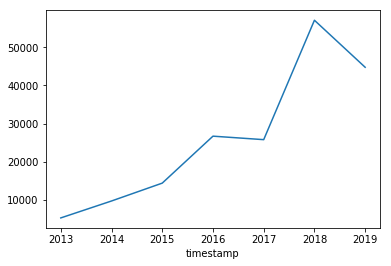

In [25]:
# Filter down:
sub = df.loc[df.kind == 'warcs'].loc[df.stream == 'frequent']

# Show year-wise breakdown, as GB:
byy = sub.groupby(df.timestamp.dt.year).file_size.sum().apply(lambda x: x/(1000*1000*1000))

# And plot it:
byy.plot.line(x='timestamp',y='file_size')


In at attempt to ensure we've understood the data, we can take the first items of each class and take a look at them, to check the classification makes sense.


In [45]:
bd = df.loc[df.stream != 'None'].groupby([df.collection, df.stream, df.timestamp.dt.year, df.kind]).apply(lambda x: x.sample(2, replace=True))
bd['file_path'].reset_index()

,collection,stream,timestamp,kind,level_4,file_path
0,npld,domain,2013,crawl-logs,1729657,/heritrix/output/logs/crawl3-20130412145049/crawl.log.20130426021230
1,npld,domain,2013,crawl-logs,1729607,/heritrix/output/logs/crawl2-20130412144921/crawl.log
2,npld,domain,2013,logs,1729608,/heritrix/output/logs/crawl2-20130412144921/crawl2-20130412144921.zip
3,npld,domain,2013,logs,1729567,/heritrix/output/logs/crawl1-20130412144637/crawl1-20130412144637.zip
4,npld,domain,2013,viral,1909585,/heritrix/output/viral/crawl0-20130412144423/BL-20130416180720829-00001-23518~crawler02~8443.warc.gz
5,npld,domain,2013,viral,1909787,/heritrix/output/viral/crawl3-20130412145049/BL-20130430134253748-00000-7659~crawler02~8446.warc.gz
6,npld,domain,2013,warcs,1943770,/heritrix/output/warcs/crawl1-20130412144637/BL-20130416145118342-01026-23604~crawler02~8444.warc.gz
7,npld,domain,2013,warcs,1924929,/heritrix/output/warcs/crawl0-20130412144423/BL-20130504205027310-04264-25313~crawler02~8443.warc.gz
8,npld,domain,2014,logs,1729602,/heritrix/output/logs/crawl1-20140610125808/scope.log.cp00025-20141204202502.gz
9,npld,domain,2014,logs,1729548,/heritrix/output/logs/crawl0-20140610125756/scope.log.cp00005-20140622191819.gz
